### Import libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Download the dataset

In [2]:
(x_train,y_train),(x_test,y_test) = load_data(path="mnist.npz")

### plot examples

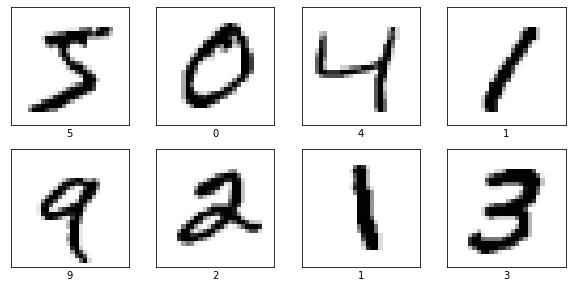

In [3]:
plt.figure(figsize=(10,10))
for i in range(0,8):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i],cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Data Normalization

In [4]:
x_train = np.reshape(x_train,(x_train.shape[0],28*28))
x_test = np.reshape(x_test,(x_test.shape[0],28*28))

In [5]:
x_train =x_train/ 255
x_test =x_test/ 255

### Crate a Neural Network

In [6]:
model = models.Sequential()
model.add(Dense(32,activation='relu',input_shape=(784,)))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [7]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

#### Train the model

In [8]:
_ = model.fit(x_train, y_train, 
              validation_data=(x_test,y_test),
              epochs = 20, 
              batch_size = 2048,
              verbose = 2,
             )

Epoch 1/20
30/30 - 1s - loss: 1.8856 - accuracy: 0.3765 - val_loss: 1.1773 - val_accuracy: 0.6905
Epoch 2/20
30/30 - 0s - loss: 0.7360 - accuracy: 0.8047 - val_loss: 0.4463 - val_accuracy: 0.8715
Epoch 3/20
30/30 - 0s - loss: 0.3989 - accuracy: 0.8860 - val_loss: 0.3354 - val_accuracy: 0.9023
Epoch 4/20
30/30 - 0s - loss: 0.3226 - accuracy: 0.9075 - val_loss: 0.2910 - val_accuracy: 0.9163
Epoch 5/20
30/30 - 0s - loss: 0.2833 - accuracy: 0.9182 - val_loss: 0.2639 - val_accuracy: 0.9248
Epoch 6/20
30/30 - 0s - loss: 0.2558 - accuracy: 0.9262 - val_loss: 0.2453 - val_accuracy: 0.9307
Epoch 7/20
30/30 - 0s - loss: 0.2358 - accuracy: 0.9328 - val_loss: 0.2317 - val_accuracy: 0.9340
Epoch 8/20
30/30 - 0s - loss: 0.2203 - accuracy: 0.9377 - val_loss: 0.2212 - val_accuracy: 0.9354
Epoch 9/20
30/30 - 0s - loss: 0.2069 - accuracy: 0.9414 - val_loss: 0.2064 - val_accuracy: 0.9401
Epoch 10/20
30/30 - 0s - loss: 0.1932 - accuracy: 0.9450 - val_loss: 0.1984 - val_accuracy: 0.9431
Epoch 11/20
30/30 -

### Save the model

In [9]:
model.save('model.h5')

### ML Server

In [10]:
%%writefile ml_server.py

import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
from flask import Flask, request

app = Flask(__name__)
model = tf.keras.models.load_model('model.h5')
feature_model = Model(model.inputs,
                     [layer.output for layer in model.layers])
_,(x_test,_) = load_data()
x_test = x_test/255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image,(1,784))
    return feature_model.predict(image_arr),image
    

@app.route('/',methods=['GET','POST'])
def index():
    if request.method=='POST':
        preds,image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction':final_preds,
            'image': image.tolist()
        })
    return 'welcome to the model server'


if __name__ == '__main__':
    app.run()

Overwriting ml_server.py


In [13]:
%%writefile app.py
import numpy as np
import streamlit as st
import requests
import json
import matplotlib.pyplot as plt


URI = "http://127.0.0.1:5000/"

st.title("Neural Network Visualizer")
st.sidebar.markdown("Input Image")

if st.button('Get random prediction'):
    response = requests.post(URI,data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image,(28,28))
    
    st.sidebar.image(image,width=150)
    
    for layer,p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        plt.figure(figsize=(32,4))
        if layer == 3:
            row = 1
            col = 10 
        else:
            row = 2 
            col = 16
        for i,number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer ==3:
                plt.xlabel(str(i),fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05, )
        plt.tight_layout()
        st.text('Layer{}'.format(layer))
        st.pyplot()
    

Overwriting app.py
